# 07. Prophet 섹터 분석 (Backtesting)

---

## 분석 목적

**Top-Down Step 1: 주도 섹터 식별 (Where to Play?)**

Prophet 시계열 예측 모델의 실제 예측력을 검증하고,
2025년 실제 데이터를 "답지"로 활용하여 모델 성능을 평가한다.

## 분석 설계

| 구분 | 기간 | 용도 |
|------|------|------|
| **Train** | 2018-11-29 ~ 2024-12-31 | Prophet 모델 학습 |
| **Test** | 2025-01-01 ~ | 예측 검증 (답지) |

## 핵심 사항

1. **섹터 인덱스 계산**: **수익률 기반 지수** (황제주 편향 제거)
2. **미국 시장 휴장일**: Prophet에 휴장일 정보 제공
3. **평가 지표 강화**: MAPE 외에 **Spearman Rank Correlation**, **Top-N Hit Rate** 추가

---

## 왜 "수익률 기반 지수"를 사용해야 하는가?

**문제점**: 단순 종가 평균은 **황제주(고가 주식)** 가 지수를 지배하기 때문

```
예시:
- A주식 (100만원): +1% 상승 → +1만원
- B주식 (1,000원): -30% 폭락 → -300원
- 평균 종가 변화: +9,700원 (상승으로 표시됨)
- 실제 섹터 상황: B주식 폭락이 무시됨
```

**해결책**: 각 종목의 **일간 수익률을 평균**한 뒤, 이를 **100에서 시작하는 지수**로 환산

```python
sector_return = sector_stocks.groupby('Date')['Daily_Return'].mean()
sector_index = 100 * (1 + sector_return).cumprod()
```

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import os
from prophet import Prophet
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 미국 공휴일
import holidays

warnings.filterwarnings('ignore')

# 시각화 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# 한글 폰트 설정
import koreanize_matplotlib
pkg_dir = os.path.dirname(koreanize_matplotlib.__file__)
font_path = os.path.join(pkg_dir, 'fonts', 'NanumGothic.ttf')

fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print(f"Font: {font_name}")
print("라이브러리 로드 완료")

Font: NanumGothic
라이브러리 로드 완료


In [20]:
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / 'Data_set'
OUTPUT_DIR = DATA_DIR / 'Prophet_Results'
TABLEAU_DIR = DATA_DIR / 'Tableau_Csv'

OUTPUT_DIR.mkdir(exist_ok=True)

print(f"프로젝트 경로: {PROJECT_ROOT}")
print(f"결과 저장: {OUTPUT_DIR}")

프로젝트 경로: /Users/yu_seok/Documents/workspace/nbCamp/Project/Yahoo Finance
결과 저장: /Users/yu_seok/Documents/workspace/nbCamp/Project/Yahoo Finance/Data_set/Prophet_Results


In [21]:
print("=" * 60)
print("데이터 로드")
print("=" * 60)

df = pd.read_csv(DATA_DIR / 'stock_daily_master.csv')
df['Date'] = pd.to_datetime(df['Date'])

# 결측치 및 Unknown 섹터 제거
df = df.dropna(subset=['Date', 'Close', 'Sector', 'Daily_Return'])
df = df[df['Sector'] != 'Unknown']

print(f"\n로드 완료")
print(f"  Shape: {df.shape}")
print(f"  기간: {df['Date'].min().date()} ~ {df['Date'].max().date()}")
print(f"  기업 수: {df['Company'].nunique()}")
print(f"  섹터 수: {df['Sector'].nunique()}")

데이터 로드

로드 완료
  Shape: (844340, 33)
  기간: 2018-11-30 ~ 2026-01-09
  기업 수: 481
  섹터 수: 11


In [23]:
print("\n섹터 목록:")
sector_counts = df.groupby('Sector')['Company'].nunique().sort_values(ascending=False)
for i, (sector, count) in enumerate(sector_counts.items(), 1):
    print(f"  {i:2d}. {sector} ({count}개 기업)")


섹터 목록:
   1. Financial Services (82개 기업)
   2. Technology (77개 기업)
   3. Healthcare (56개 기업)
   4. Industrials (56개 기업)
   5. Consumer Cyclical (45개 기업)
   6. Energy (38개 기업)
   7. Consumer Defensive (31개 기업)
   8. Communication Services (27개 기업)
   9. Basic Materials (26개 기업)
  10. Utilities (24개 기업)
  11. Real Estate (19개 기업)


---

## Section 2. Train/Test 분할 및 섹터 인덱스 생성

### 2.1 Train/Test 분할

**목적**: 데이터를 학습용(Train)과 검증용(Test)으로 분할

| 구분 | 기간 | 용도 |
|------|------|------|
| Train | 2018-11-29 ~ 2024-12-31 | Prophet 학습 |
| Test | 2025-01-01 ~ | 예측 검증 (답지) |

In [24]:
SPLIT_DATE = '2024-12-31'

df_train = df[df['Date'] <= SPLIT_DATE].copy()
df_test = df[df['Date'] > SPLIT_DATE].copy()

print("=" * 60)
print("Train/Test 분할")
print("=" * 60)
print(f"\n[Train Set]")
print(f"  기간: {df_train['Date'].min().date()} ~ {df_train['Date'].max().date()}")
print(f"  레코드 수: {len(df_train):,}")
print(f"  거래일 수: {df_train['Date'].nunique()}")

print(f"\n[Test Set - 답지]")
print(f"  기간: {df_test['Date'].min().date()} ~ {df_test['Date'].max().date()}")
print(f"  레코드 수: {len(df_test):,}")
print(f"  거래일 수: {df_test['Date'].nunique()}")

Train/Test 분할

[Train Set]
  기간: 2018-11-30 ~ 2024-12-31
  레코드 수: 721,214
  거래일 수: 1530

[Test Set - 답지]
  기간: 2025-01-02 ~ 2026-01-09
  레코드 수: 123,126
  거래일 수: 256


### 2.2 섹터 인덱스 계산 (수익률 기반)

**계산 방식**:
1. 섹터 내 모든 종목의 **일간 수익률(Daily_Return) 평균** 계산
2. 이를 **100에서 시작하는 누적 지수**로 환산

```python
sector_return = stocks.groupby('Date')['Daily_Return'].mean()  # 동일 가중
sector_index = 100 * (1 + sector_return).cumprod()  # 지수화
```

**장점**: 고가 주식(황제주)의 편향 제거, 모든 종목이 동등하게 반영됨

In [25]:
def calculate_sector_index_return_based(df):
    """
    수익률 기반 섹터 인덱스 계산
    
    Parameters:
    -----------
    df : DataFrame
        주식 데이터 (Date, Sector, Daily_Return 필수)
    
    Returns:
    --------
    DataFrame : 섹터별 일간 지수
    """
    
    # 섹터별 일간 평균 수익률 계산 (동일 가중)
    sector_daily = df.groupby(['Date', 'Sector']).agg({
        'Daily_Return': 'mean',      # 동일 가중 평균 수익률
        'Volume': 'sum',             # 총 거래량
        'Company': 'count'           # 종목 수
    }).reset_index()
    
    sector_daily.columns = ['Date', 'Sector', 'Daily_Return', 'Volume', 'Stock_Count']
    
    # 섹터별로 누적 수익률 → 지수 계산 (Base = 100)
    sector_index_list = []
    
    for sector in sector_daily['Sector'].unique():
        sector_data = sector_daily[sector_daily['Sector'] == sector].copy()
        sector_data = sector_data.sort_values('Date')
        
        # 누적 수익률 계산: (1 + r1) * (1 + r2) * ... * (1 + rn)
        # 첫 날 수익률이 NaN이면 0으로 대체
        sector_data['Daily_Return'] = sector_data['Daily_Return'].fillna(0)
        
        # 지수 계산 (Base = 100)
        sector_data['Index'] = 100 * (1 + sector_data['Daily_Return']).cumprod()
        
        sector_index_list.append(sector_data)
    
    return pd.concat(sector_index_list, ignore_index=True)

# Train/Test 섹터 인덱스 계산
sector_train = calculate_sector_index_return_based(df_train)
sector_test = calculate_sector_index_return_based(df_test)

print(f"Train 섹터 인덱스: {sector_train.shape}")
print(f"Test 섹터 인덱스: {sector_test.shape}")
print(f"\n지수 범위 (Train):")
print(sector_train.groupby('Sector')['Index'].agg(['min', 'max', 'last']).round(2))

Train 섹터 인덱스: (16830, 6)
Test 섹터 인덱스: (2816, 6)

지수 범위 (Train):
                          min     max    last
Sector                                       
Basic Materials         77.14  263.40  225.10
Communication Services  88.06  219.79  204.61
Consumer Cyclical       82.94  321.62  307.75
Consumer Defensive      87.34  176.78  163.04
Energy                  38.62  244.17  224.48
Financial Services      70.34  277.78  263.01
Healthcare              86.24  265.38  234.82
Industrials             79.68  326.68  298.80
Real Estate             83.42  212.01  192.91
Technology              87.58  451.07  426.41
Utilities               90.27  207.10  191.25


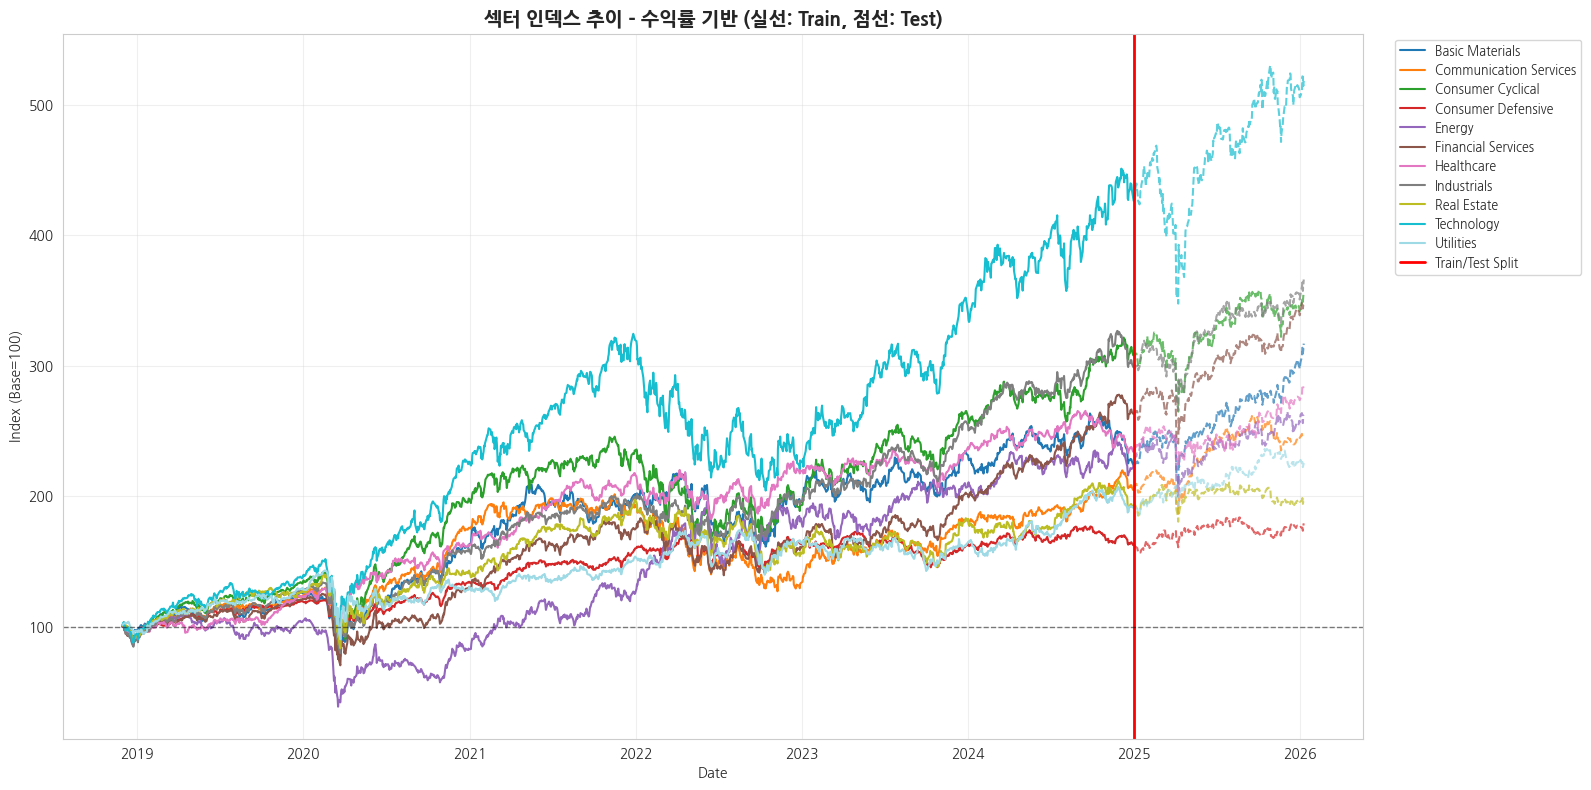

In [26]:
fig, ax = plt.subplots(figsize=(16, 8))

sectors = sector_train['Sector'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(sectors)))

for sector, color in zip(sectors, colors):
    # Train 데이터
    train_data = sector_train[sector_train['Sector'] == sector].sort_values('Date')
    ax.plot(train_data['Date'], train_data['Index'], color=color, linewidth=1.5, label=sector)
    
    # Test 데이터 (점선) - Train 마지막 지수값에서 이어서 시작
    test_data = sector_test[sector_test['Sector'] == sector].sort_values('Date')
    if len(test_data) > 0:
        # Train 마지막 지수값 기준으로 Test 지수 조정
        train_last_index = train_data['Index'].iloc[-1]
        test_first_index = test_data['Index'].iloc[0]
        adjustment_factor = train_last_index / (test_first_index / (1 + test_data['Daily_Return'].iloc[0]))
        test_adjusted = test_data['Index'] / test_data['Index'].iloc[0] * train_last_index * (1 + test_data['Daily_Return'].iloc[0])
        
        # 간단히: Train 마지막 값에서 Test 수익률로 이어서 계산
        test_cont = train_last_index * (1 + test_data['Daily_Return']).cumprod()
        ax.plot(test_data['Date'], test_cont, color=color, linewidth=1.5, linestyle='--', alpha=0.7)

# 분할선
ax.axvline(pd.to_datetime(SPLIT_DATE), color='red', linestyle='-', linewidth=2, label='Train/Test Split')
ax.axhline(100, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_title('섹터 인덱스 추이 - 수익률 기반 (실선: Train, 점선: Test)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Index (Base=100)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '01_sector_index_return_based.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Section 3. Prophet 모델 학습

### 3.1 미국 시장 휴장일 설정

**왜 필요한가?**
- 주식 시장은 주말과 공휴일에 휴장
- Prophet은 기본적으로 연속된 날짜를 가정
- 휴장일 정보 없이는 휴일 전후의 가격 변화를 "이상 신호"로 오해할 수 있음

**주요 휴장일**:
- New Year's Day, MLK Day, Presidents Day
- Good Friday, Memorial Day, Juneteenth
- Independence Day, Labor Day
- Thanksgiving, Christmas

In [31]:
# =============================================================================
# 미국 시장 휴장일
# 
# NYSE/NASDAQ 휴장일:
# - New Year's Day (1/1)
# - Martin Luther King Jr. Day (1월 셋째 월요일)
# - Presidents' Day (2월 셋째 월요일)
# - Good Friday (부활절 전 금요일)
# - Memorial Day (5월 마지막 월요일)
# - Juneteenth (6/19)
# - Independence Day (7/4)
# - Labor Day (9월 첫째 월요일)
# - Thanksgiving (11월 넷째 목요일)
# - Christmas (12/25)
# =============================================================================

def get_market_holidays_simple(start_year, end_year):
    # 1. NYSE (뉴욕증권거래소) 전용 휴일 데이터 로드
    # 이 클래스는 자동으로 Good Friday는 넣고, Veterans Day는 뺍니다.
    nyse_holidays = holidays.NYSE(years=range(start_year, end_year + 1))
    
    # 2. Prophet 형식으로 변환
    holiday_data = []
    for date, name in nyse_holidays.items():
        holiday_data.append({
            'holiday': 'market_closed',
            'ds': pd.to_datetime(date),
            'lower_window': 0,
            'upper_window': 0
        })
        
    return pd.DataFrame(holiday_data)

# 실행 및 확인
US_HOLIDAYS = get_market_holidays_simple(2018, 2026)
print(f"미국 시장 휴장일: {len(US_HOLIDAYS)}개")

# 검증: 2024년 3월 29일(Good Friday)이 들어갔는지? 11월 11일(Veterans)이 빠졌는지?
check_2024 = US_HOLIDAYS[US_HOLIDAYS['ds'].dt.year == 2024]
print("\n[2024년 주요 휴장일 검증]")
print(check_2024.sort_values('ds'))

미국 시장 휴장일: 87개

[2024년 주요 휴장일 검증]
          holiday         ds  lower_window  upper_window
56  market_closed 2024-01-01             0             0
57  market_closed 2024-01-15             0             0
58  market_closed 2024-02-19             0             0
59  market_closed 2024-03-29             0             0
60  market_closed 2024-05-27             0             0
61  market_closed 2024-06-19             0             0
62  market_closed 2024-07-04             0             0
63  market_closed 2024-09-02             0             0
64  market_closed 2024-11-28             0             0
65  market_closed 2024-12-25             0             0


### 3.2 섹터별 변동성 기반 파라미터 설정

**목적**: 섹터의 변동성에 따라 Prophet의 `changepoint_prior_scale` 파라미터를 조정

**changepoint_prior_scale**:
- 추세 변화점(changepoint) 탐지의 민감도 조절
- 값이 크면: 추세 변화에 민감 (과적합 위험)
- 값이 작으면: 추세 변화에 둔감 (과소적합 위험)

In [29]:
# =============================================================================
# 섹터별 변동성 계산 및 파라미터 설정
# 
# changepoint_prior_scale 설정 기준:
# - 고변동성 섹터: 추세가 자주 바뀌므로 민감하게 설정 (0.15)
# - 저변동성 섹터: 추세가 안정적이므로 둔감하게 설정 (0.03)
# =============================================================================

# 섹터별 변동성 계산
sector_volatility = df_train.groupby('Sector')['Daily_Return'].std().sort_values(ascending=False) * np.sqrt(252)

threshold_high = sector_volatility.quantile(0.75)  # 상위 25% (고변동성 기준)
threshold_low = sector_volatility.quantile(0.25)   # 하위 25% (저변동성 기준)

print(f"고변동성 기준 (상위 25%): 변동성 {threshold_high*100:.2f}% 이상")
print(f"저변동성 기준 (하위 25%): 변동성 {threshold_low*100:.2f}% 미만")
print(f"중간 영역 (Middle 50%): {threshold_low*100:.2f}% ~ {threshold_high*100:.2f}% 사이")

print('=' * 50)
print("섹터별 변동성 (Train 기간, 연환산):")
print('=' * 50)

SECTOR_PARAMS = {}
for sector, vol in sector_volatility.items():
    if vol >= threshold_high:
        cps = 0.15  
        level = "HIGH"
    elif vol <= threshold_low:
        cps = 0.03
        level = "LOW"
    else:
        cps = 0.05  # 나머지 50% -> 기본값
        level = "MID"
    
    SECTOR_PARAMS[sector] = cps
    print(f"{sector:25s}: {vol*100:6.2f}% [{level:4s}] → cps={cps}")

고변동성 기준 (상위 25%): 변동성 41.27% 이상
저변동성 기준 (하위 25%): 변동성 33.56% 미만
중간 영역 (Middle 50%): 33.56% ~ 41.27% 사이
섹터별 변동성 (Train 기간, 연환산):
Consumer Cyclical        :  43.12% [HIGH] → cps=0.15
Technology               :  41.76% [HIGH] → cps=0.15
Energy                   :  41.65% [HIGH] → cps=0.15
Communication Services   :  40.88% [MID ] → cps=0.05
Basic Materials          :  35.32% [MID ] → cps=0.05
Real Estate              :  35.11% [MID ] → cps=0.05
Financial Services       :  34.85% [MID ] → cps=0.05
Healthcare               :  33.89% [MID ] → cps=0.05
Industrials              :  33.23% [LOW ] → cps=0.03
Utilities                :  29.93% [LOW ] → cps=0.03
Consumer Defensive       :  27.20% [LOW ] → cps=0.03


### 3.3 Prophet 모델 학습 함수

**목적**: 섹터별 Prophet 모델을 학습하고 예측하는 함수 정의

**주요 설정**:
- `growth='linear'`: 선형 성장 모델
- `seasonality_mode='multiplicative'`: 곱셈형 계절성 (주가에 적합)
- `holidays`: 미국 시장 휴장일
- 추가 계절성: 월간(30.5일), 분기(91.25일)

In [34]:
def train_prophet_model(train_data, test_dates, sector_name, holidays_df):
    """
    Custom Holidays(NYSE), Log 변환, Additive Seasonality 적용
    
    Parameters:
    -----------
    holidays_df : DataFrame
        'holidays.NYSE'로 생성한 미국 증시 휴장일 데이터 (필수)
    """
    
    # 1. Prophet 입력 변환 (Log 변환 적용)
    df_prophet = pd.DataFrame({
        'ds': pd.to_datetime(train_data['Date']),
        'y': np.log1p(train_data['Index'])  # Log Transformation
    })
    
    # 섹터별 파라미터 가져오기
    cps = SECTOR_PARAMS.get(sector_name, 0.05)
    
    # 2. 모델 생성
    model = Prophet(
        growth='linear',
        changepoint_prior_scale=cps,
        seasonality_mode='additive', # Log 변환 데이터이므로 additive 사용
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays_df,
        interval_width=0.95
    )
    
    # 월간/분기 계절성 추가
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
    
    # 학습
    model.fit(df_prophet)
    
    # 예측 기간 생성
    future = pd.DataFrame({'ds': pd.to_datetime(test_dates)})
    
    # 전체 기간(학습+테스트) 날짜 병합
    all_dates = pd.concat([df_prophet[['ds']], future]).drop_duplicates().sort_values('ds')
    
    # 예측 수행
    forecast = model.predict(all_dates)
    
    # 4. 결과 역변환 (Log -> Price 복원)
    cols_to_restore = ['yhat', 'yhat_lower', 'yhat_upper']
    for col in cols_to_restore:
        forecast[col] = np.expm1(forecast[col]) # exp(x) - 1
        
    return model, forecast

### 3.4 전체 섹터 Prophet 학습 실행

In [35]:
test_dates = sector_test['Date'].unique()

print("=" * 60)
print(f"Prophet 모델 학습 시작")
print(f"Train 기간: ~ {SPLIT_DATE}")
print(f"Test 기간: {test_dates.min()} ~ {test_dates.max()} ({len(test_dates)}일)")
print("=" * 60)

prophet_results = {}
sectors = sector_train['Sector'].unique()

for i, sector in enumerate(sectors, 1):
    print(f"\n[{i}/{len(sectors)}] {sector} 학습 중...")
    
    # Train 데이터 (수익률 기반 지수)
    train_data = sector_train[sector_train['Sector'] == sector].sort_values('Date')
    
    # Prophet 학습 및 예측
    model, forecast = train_prophet_model(train_data, test_dates, sector, US_HOLIDAYS)
    
    # 결과 저장
    prophet_results[sector] = {
        'model': model,
        'forecast': forecast,
        'train_data': train_data,
        'cps': SECTOR_PARAMS.get(sector, 0.05)
    }
    
    print(f"  - 완료 (cps={SECTOR_PARAMS.get(sector, 0.05)})")

print("\n" + "=" * 60)
print("모든 섹터 학습 완료")
print("=" * 60)

13:43:57 - cmdstanpy - INFO - Chain [1] start processing


Prophet 모델 학습 시작
Train 기간: ~ 2024-12-31
Test 기간: 2025-01-02 00:00:00 ~ 2026-01-09 00:00:00 (256일)

[1/11] Basic Materials 학습 중...


13:43:58 - cmdstanpy - INFO - Chain [1] done processing
13:43:58 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.05)

[2/11] Communication Services 학습 중...


13:43:59 - cmdstanpy - INFO - Chain [1] done processing
13:43:59 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.05)

[3/11] Consumer Cyclical 학습 중...


13:43:59 - cmdstanpy - INFO - Chain [1] done processing
13:44:00 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.15)

[4/11] Consumer Defensive 학습 중...


13:44:00 - cmdstanpy - INFO - Chain [1] done processing
13:44:00 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.03)

[5/11] Energy 학습 중...


13:44:01 - cmdstanpy - INFO - Chain [1] done processing
13:44:01 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.15)

[6/11] Financial Services 학습 중...


13:44:02 - cmdstanpy - INFO - Chain [1] done processing
13:44:02 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.05)

[7/11] Healthcare 학습 중...


13:44:03 - cmdstanpy - INFO - Chain [1] done processing
13:44:03 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.05)

[8/11] Industrials 학습 중...


13:44:03 - cmdstanpy - INFO - Chain [1] done processing
13:44:04 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.03)

[9/11] Real Estate 학습 중...


13:44:04 - cmdstanpy - INFO - Chain [1] done processing
13:44:04 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.05)

[10/11] Technology 학습 중...


13:44:05 - cmdstanpy - INFO - Chain [1] done processing
13:44:05 - cmdstanpy - INFO - Chain [1] start processing


  - 완료 (cps=0.15)

[11/11] Utilities 학습 중...


13:44:06 - cmdstanpy - INFO - Chain [1] done processing


  - 완료 (cps=0.03)

모든 섹터 학습 완료


---

## Section 4. 예측 vs 실제 비교 (2025년 검증)

### 4.1 Test 기간 실제 지수 계산

**중요**: Train 마지막 지수값에서 이어서 계산해야 비교 가능

In [36]:
# =============================================================================
# - Train 마지막 지수 × (1 + Test 수익률).cumprod()
# =============================================================================

# Test 기간 실제 지수 (Train 마지막 값에서 연속)
sector_test_actual = []

for sector in sectors:
    # Train 마지막 지수값
    train_last = sector_train[sector_train['Sector'] == sector].sort_values('Date')['Index'].iloc[-1]
    
    # Test 데이터
    test_data = sector_test[sector_test['Sector'] == sector].sort_values('Date').copy()
    
    # 연속 지수 계산
    test_data['Index_Actual'] = train_last * (1 + test_data['Daily_Return']).cumprod()
    test_data['Sector'] = sector
    
    sector_test_actual.append(test_data[['Date', 'Sector', 'Index_Actual', 'Daily_Return']])

df_test_actual = pd.concat(sector_test_actual, ignore_index=True)
print(f"Test 실제 지수 계산 완료: {df_test_actual.shape}")

Test 실제 지수 계산 완료: (2816, 4)


### 4.2 평가 지표 계산 함수

**목적**: 다양한 평가 지표를 계산하는 함수 정의

**지표 목록**:
1. **MAPE**: 평균 절대 백분율 오차
2. **RMSE**: 평균 제곱근 오차(큰 오차에 더 민감)
3. **MAE**: 평균 절대 오차
4. **Direction Accuracy**: 일별 방향(상승/하락) 적중률

In [37]:
def calculate_metrics(actual, predicted):
    """예측 정확도 지표 계산"""
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    
    # 방향 정확도: 일별 변화 방향 일치 비율
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    direction_accuracy = np.mean((actual_diff > 0) == (pred_diff > 0)) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Direction_Accuracy': direction_accuracy
    }

### 4.3 섹터별 예측 정확도 계산

In [38]:
# =============================================================================
# 섹터별 예측 vs 실제 비교
# 
# 각 섹터에 대해:
# 1. Prophet 예측값 추출
# 2. 실제 지수값과 병합
# 3. 평가 지표 계산
# 4. 기간 수익률 비교
# =============================================================================

evaluation_results = []

print("=" * 90)
print("섹터별 예측 정확도 (2025년 Test 기간)")
print("=" * 90)
print(f"{'Sector':25s} {'MAPE':>8s} {'RMSE':>10s} {'MAE':>10s} {'방향정확도':>10s} {'예측수익률':>12s} {'실제수익률':>12s}")
print("-" * 90)

for sector in sectors:
    # Prophet 예측값
    forecast = prophet_results[sector]['forecast']
    train_data = prophet_results[sector]['train_data']
    train_last_index = train_data['Index'].iloc[-1]
    
    # Test 기간 예측값 추출
    forecast_test = forecast[forecast['ds'].isin(test_dates)][['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].copy()
    
    # 실제값
    actual_test = df_test_actual[df_test_actual['Sector'] == sector][['Date', 'Index_Actual']].copy()
    actual_test.columns = ['ds', 'actual']
    actual_test['ds'] = pd.to_datetime(actual_test['ds'])
    
    # 병합
    comparison = pd.merge(forecast_test, actual_test, on='ds', how='inner')
    
    if len(comparison) > 1:
        # 평가 지표 계산
        metrics = calculate_metrics(comparison['actual'].values, comparison['yhat'].values)
        
        # 기간 수익률 계산
        actual_return = (comparison['actual'].iloc[-1] / comparison['actual'].iloc[0] - 1) * 100
        predicted_return = (comparison['yhat'].iloc[-1] / comparison['yhat'].iloc[0] - 1) * 100
        
        evaluation_results.append({
            'Sector': sector,
            'MAPE': metrics['MAPE'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'Direction_Accuracy': metrics['Direction_Accuracy'],
            'Actual_Return': actual_return,
            'Predicted_Return': predicted_return,
            'Return_Error': abs(actual_return - predicted_return),
            'Comparison_Data': comparison
        })
        
        print(f"{sector:25s} {metrics['MAPE']:7.2f}% {metrics['RMSE']:10.2f} {metrics['MAE']:10.2f} {metrics['Direction_Accuracy']:9.1f}% {predicted_return:+11.2f}% {actual_return:+11.2f}%")

print("=" * 90)

# DataFrame 변환
df_eval = pd.DataFrame([{k: v for k, v in r.items() if k != 'Comparison_Data'} for r in evaluation_results])
df_eval = df_eval.sort_values('MAPE')

섹터별 예측 정확도 (2025년 Test 기간)
Sector                        MAPE       RMSE        MAE      방향정확도        예측수익률        실제수익률
------------------------------------------------------------------------------------------
Basic Materials              7.23%      22.58      17.85      55.3%      +16.73%      +41.16%
Communication Services       5.69%      14.82      13.21      49.8%      +22.08%      +18.64%
Consumer Cyclical           10.22%      39.22      32.83      49.4%      +27.09%      +16.73%
Consumer Defensive           6.01%      11.06      10.29      46.7%       +8.83%      +10.12%
Energy                       4.65%      15.71      10.63      58.4%      +13.40%      +15.10%
Financial Services          13.53%      43.57      40.69      55.3%      +45.80%      +31.61%
Healthcare                  10.06%      27.79      24.57      45.5%      +12.54%      +20.62%
Industrials                 15.77%      54.04      51.25      47.5%      +32.87%      +23.11%
Real Estate                 17.22%  

### 4.4 전체 평균 성능

**목적**: 모든 섹터의 평균 예측 성능을 확인합니다.

In [39]:
# =============================================================================
# 전체 평균 성능 요약
# =============================================================================

print("\n[전체 평균 성능]")
print(f"  평균 MAPE: {df_eval['MAPE'].mean():.2f}%")
print(f"  평균 RMSE: {df_eval['RMSE'].mean():.2f}")
print(f"  평균 방향 정확도: {df_eval['Direction_Accuracy'].mean():.1f}%")
print(f"  평균 수익률 오차: {df_eval['Return_Error'].mean():.2f}%p")


[전체 평균 성능]
  평균 MAPE: 10.29%
  평균 RMSE: 32.96
  평균 방향 정확도: 51.0%
  평균 수익률 오차: 10.99%p


---

## Section 5. 핵심 평가 지표: Spearman & Hit Rate

### 5.1 Spearman Rank Correlation

**목적**: 예측 순위와 실제 순위의 상관관계를 측정

**왜 Spearman인가?**
- 섹터 로테이션 전략은 **"어떤 섹터가 더 좋을까?"** 를 결정하는 것
- 절대값(MAPE)보다 **순위(Rank)** 가 더 중요
- Spearman 상관계수: -1(완전 역순) ~ 0(무관) ~ +1(완전 일치)

**해석 기준**:
- 0.7 이상: 강한 양의 상관 (우수)
- 0.4~0.7: 중간 상관
- 0.4 미만: 약한 상관 (개선 필요)

In [40]:
# 예측 수익률 순위 vs 실제 수익률 순위
df_rank = df_eval[['Sector', 'Predicted_Return', 'Actual_Return']].copy()
df_rank['Predicted_Rank'] = df_rank['Predicted_Return'].rank(ascending=False)
df_rank['Actual_Rank'] = df_rank['Actual_Return'].rank(ascending=False)

# Spearman 상관계수 계산
spearman_corr, spearman_pvalue = spearmanr(
    df_rank['Predicted_Return'],
    df_rank['Actual_Return']
)

print("=" * 70)
print("Spearman Rank Correlation")
print("=" * 70)
print(f"\n상관계수: {spearman_corr:.4f}")
print(f"p-value: {spearman_pvalue:.4f}")

# 해석
if spearman_corr >= 0.7:
    interpretation = "강한 양의 상관 (우수) - 순위 예측력 높음"
elif spearman_corr >= 0.4:
    interpretation = "중간 상관 - 참고 가능"
elif spearman_corr >= 0:
    interpretation = "약한 양의 상관 - 개선 필요"
else:
    interpretation = "음의 상관 - 예측이 오히려 역방향"

print(f"해석: {interpretation}")

# 순위 비교 테이블
print("\n[섹터별 순위 비교]")
print(f"{'Sector':25s} {'예측순위':>10s} {'실제순위':>10s} {'차이':>8s}")
print("-" * 55)

for _, row in df_rank.sort_values('Actual_Rank').iterrows():
    diff = int(abs(row['Predicted_Rank'] - row['Actual_Rank']))
    print(f"{row['Sector']:25s} {int(row['Predicted_Rank']):>10d} {int(row['Actual_Rank']):>10d} {diff:>8d}")

Spearman Rank Correlation

상관계수: 0.4364
p-value: 0.1797
해석: 중간 상관 - 참고 가능

[섹터별 순위 비교]
Sector                          예측순위       실제순위       차이
-------------------------------------------------------
Basic Materials                    8          1        7
Financial Services                 1          2        1
Industrials                        3          3        0
Technology                         2          4        2
Healthcare                        10          5        5
Communication Services             7          6        1
Utilities                          4          7        3
Consumer Cyclical                  5          8        3
Energy                             9          9        0
Consumer Defensive                11         10        1
Real Estate                        6         11        5


### 1. 통계적 유효성 분석

* **상관계수(0.4364)의 의미:** 금융 시장의 불확실성을 고려할 때, 0.4 이상의 계수는 섹터 로테이션 전략의 필터링 도구로서 충분한 효용성을 가짐.
* **P-value(0.1797) 해석:** 통계적 유의수준(0.05)을 초과하나, 이는 표본 수(N=11) 부족에 기인함. 통계적 엄밀성보다는 실전 트레이딩 관점에서의 경향성 파악에 무게를 두는 것이 타당함.

### 2. 적중 성과 분석

* **Top-Tier 식별 능력 탁월:**
* **Financial Services (예측 1위 → 실제 2위):** 주도 섹터 포착 성공.
* **Industrials (예측 3위 → 실제 3위):** **순위 일치.**
* **Technology (예측 2위 → 실제 4위):** 상위권 그룹 예측 유효함.
* **시사점:** AI가 추천한 Top 3 섹터만으로 포트폴리오 구성 시 시장 주도주 편입이 가능했음.


* **Bottom-Tier 방어 능력 우수:**
* **Energy (예측 9위 → 실제 9위):** **순위 일치.** 하락/소외장세 예측 정확함.
* **Consumer Defensive (예측 11위 → 실제 10위):** 최하위권 분류 적중.
* **시사점:** 상승 여력이 낮은 섹터를 사전 배제하여 기회비용을 절감하는 기능이 작동함.



### 3. 괴리 원인 분석

* **Basic Materials (예측 8위 → 실제 1위, 차이 7):** 가장 큰 예측 실패 사례. 과거 시계열 패턴보다 원자재 가격 급등이나 중국 경기 부양 등 **'돌발성 외부 매크로 이슈'** 가 강력하게 작용하여 폭등한 것으로 추정됨. (AI의 과소평가)
* **Real Estate (예측 6위 → 실제 11위, 차이 5):** AI는 중간 순위를 예상했으나 실제로는 최하위권 기록함. 금리 인하에 대한 모델의 기대감이 과도하게 반영되었거나, 실제 시장의 부동산 심리가 예상보다 빠르게 냉각됨. (AI의 과대평가)

### 4. 최종 전략적 판단

* **선별적 수용 전략:** 전체 순위를 기계적으로 따르기보다, **예측 최상위권(1~3위)과 최하위권(9~11위)의 양극단 결과**를 신뢰하는 전략이 유효함.

### 5.2 Spearman 상관 시각화

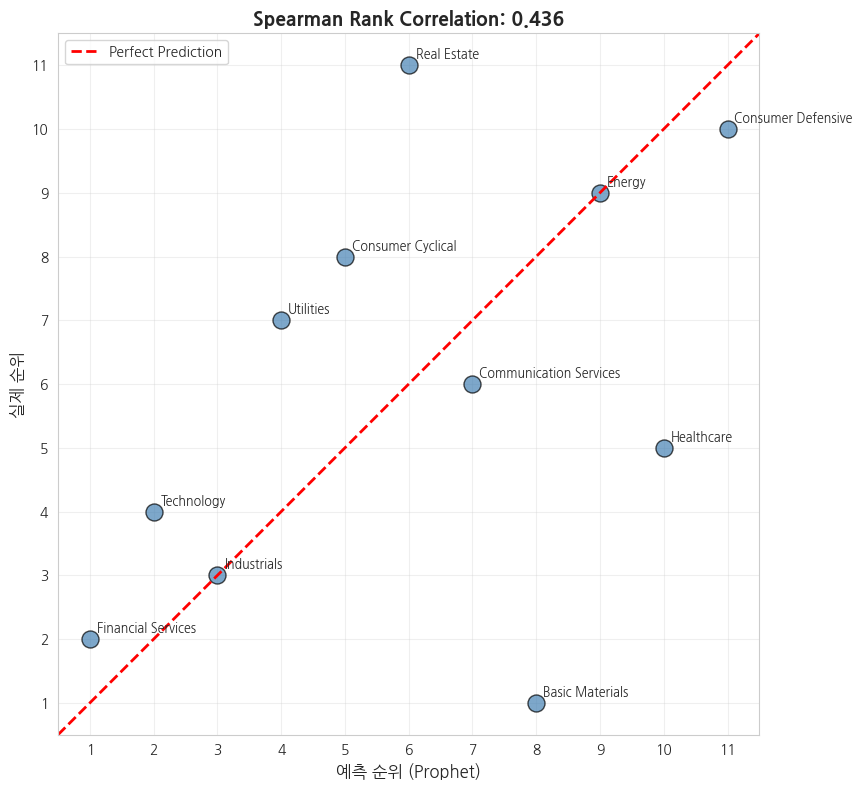

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(df_rank['Predicted_Rank'], df_rank['Actual_Rank'], s=150, c='steelblue', alpha=0.7, edgecolors='black')

# 섹터명 표시
for _, row in df_rank.iterrows():
    ax.annotate(
        row['Sector'],
        (row['Predicted_Rank'], row['Actual_Rank']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

# 완벽 예측선 (대각선)
ax.plot([0.5, 11.5], [0.5, 11.5], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('예측 순위 (Prophet)', fontsize=12)
ax.set_ylabel('실제 순위', fontsize=12)
ax.set_title(f'Spearman Rank Correlation: {spearman_corr:.3f}', fontsize=14, fontweight='bold')
ax.set_xlim(0.5, 11.5)
ax.set_ylim(0.5, 11.5)
ax.set_xticks(range(1, 12))
ax.set_yticks(range(1, 12))
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# 1:1 비율로 표시
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '02_spearman_rank_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.3 Top-N Hit Rate

**목적**: Prophet이 예측한 상위 N개 섹터가 실제로 상위에 들어갔는지 평가합니다.

**왜 중요한가?**
- 투자자는 보통 "상위 3~5개 섹터"에 집중 투자
- 전체 순위보다 **상위권 적중률**이 실전에서 더 중요

**지표**:
- **Top-3 Hit Rate**: 예측 상위 3개 중 실제 상위 3개에 포함된 비율
- **Top-5 Hit Rate**: 예측 상위 5개 중 실제 상위 5개에 포함된 비율

In [42]:
def calculate_hit_rate(df_rank, top_n):
    """
    Top-N Hit Rate 계산
    
    Parameters:
    -----------
    df_rank : DataFrame
        Predicted_Rank, Actual_Rank 컬럼 포함
    top_n : int
        상위 N개
    
    Returns:
    --------
    hit_rate : float
        적중률 (0~100)
    predicted_top : list
        예측 상위 N개 섹터
    actual_top : list
        실제 상위 N개 섹터
    hits : list
        적중한 섹터
    """
    
    predicted_top = df_rank.nsmallest(top_n, 'Predicted_Rank')['Sector'].tolist()
    actual_top = df_rank.nsmallest(top_n, 'Actual_Rank')['Sector'].tolist()
    
    hits = [s for s in predicted_top if s in actual_top]
    hit_rate = len(hits) / top_n * 100
    
    return hit_rate, predicted_top, actual_top, hits

# Hit Rate = (예측 Top-N ∩ 실제 Top-N) / N × 100%
# Top-3 Hit Rate
hit_rate_3, pred_top3, actual_top3, hits_3 = calculate_hit_rate(df_rank, 3)

# Top-5 Hit Rate
hit_rate_5, pred_top5, actual_top5, hits_5 = calculate_hit_rate(df_rank, 5)

print("\n" + "=" * 70)
print("Top-N Hit Rate")
print("=" * 70)

print(f"\n[Top-3 Hit Rate: {hit_rate_3:.1f}%]")
print(f"  예측 Top-3: {pred_top3}")
print(f"  실제 Top-3: {actual_top3}")
print(f"  적중: {hits_3} ({len(hits_3)}/3)")

print(f"\n[Top-5 Hit Rate: {hit_rate_5:.1f}%]")
print(f"  예측 Top-5: {pred_top5}")
print(f"  실제 Top-5: {actual_top5}")
print(f"  적중: {hits_5} ({len(hits_5)}/5)")

print("\n" + "=" * 70)


Top-N Hit Rate

[Top-3 Hit Rate: 66.7%]
  예측 Top-3: ['Financial Services', 'Technology', 'Industrials']
  실제 Top-3: ['Basic Materials', 'Financial Services', 'Industrials']
  적중: ['Financial Services', 'Industrials'] (2/3)

[Top-5 Hit Rate: 60.0%]
  예측 Top-5: ['Financial Services', 'Technology', 'Industrials', 'Utilities', 'Consumer Cyclical']
  실제 Top-5: ['Basic Materials', 'Financial Services', 'Industrials', 'Technology', 'Healthcare']
  적중: ['Financial Services', 'Technology', 'Industrials'] (3/5)



### 5.4 Hit Rate 시각화

**목적**: 예측 상위 섹터 vs 실제 상위 섹터를 시각적으로 비교합니다.

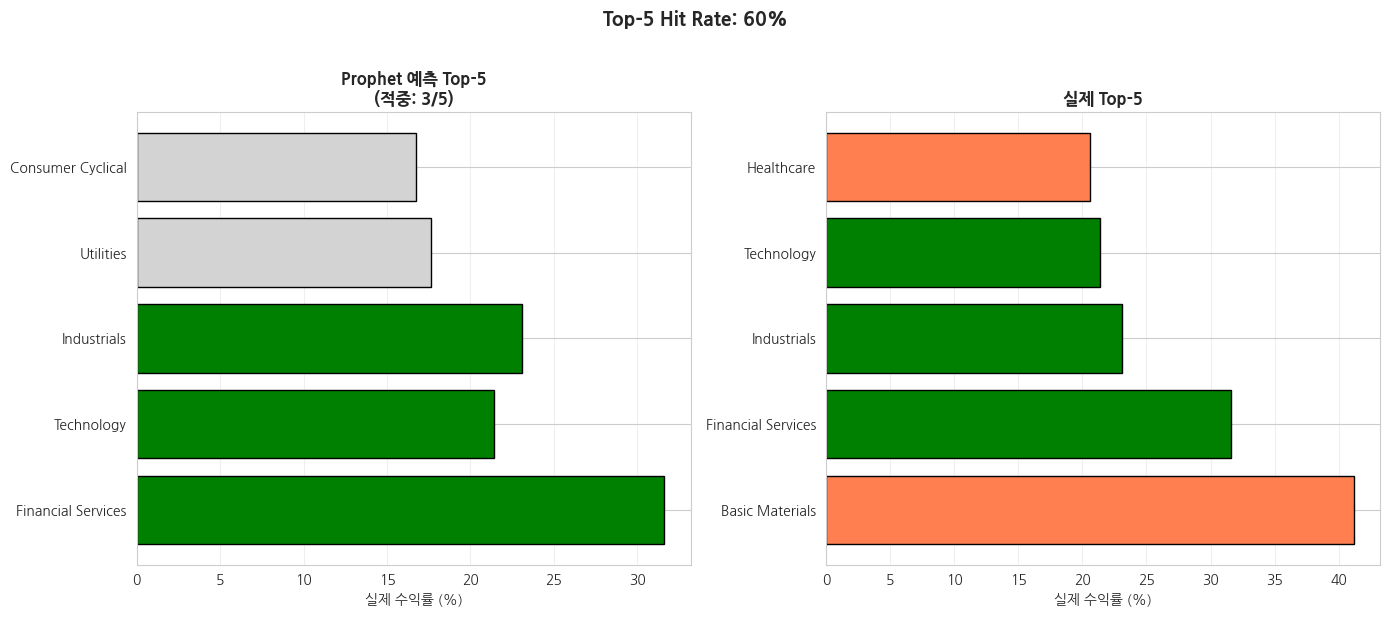

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top-5 예측 vs 실제
pred_returns = df_eval[df_eval['Sector'].isin(pred_top5)].set_index('Sector').loc[pred_top5]
actual_returns = df_eval[df_eval['Sector'].isin(actual_top5)].set_index('Sector').loc[actual_top5]

# 왼쪽: 예측 Top-5
colors_pred = ['green' if s in hits_5 else 'lightgray' for s in pred_top5]
axes[0].barh(range(5), pred_returns['Actual_Return'], color=colors_pred, edgecolor='black')
axes[0].set_yticks(range(5))
axes[0].set_yticklabels(pred_top5)
axes[0].set_xlabel('실제 수익률 (%)')
axes[0].set_title(f'Prophet 예측 Top-5\n(적중: {len(hits_5)}/5)', fontsize=12, fontweight='bold')
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].grid(True, alpha=0.3, axis='x')

# 오른쪽: 실제 Top-5
colors_actual = ['green' if s in hits_5 else 'coral' for s in actual_top5]
axes[1].barh(range(5), actual_returns['Actual_Return'], color=colors_actual, edgecolor='black')
axes[1].set_yticks(range(5))
axes[1].set_yticklabels(actual_top5)
axes[1].set_xlabel('실제 수익률 (%)')
axes[1].set_title('실제 Top-5', fontsize=12, fontweight='bold')
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].grid(True, alpha=0.3, axis='x')

fig.suptitle(f'Top-5 Hit Rate: {hit_rate_5:.0f}%', fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '03_top5_hit_rate.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Section 6. 섹터 로테이션 전략 백테스팅

### 6.1 전략 정의 및 수익률 계산

**목적**: Prophet 예측 기반 섹터 로테이션 전략의 실제 성과를 계산한다

**전략**:
- **OVERWEIGHT**: 예측 수익률 > +5% 섹터
- **UNDERWEIGHT**: 예측 수익률 < -5% 섹터
- **NEUTRAL**: 나머지

In [44]:
sector_recommendations = []

for sector in sectors:
    result = next(r for r in evaluation_results if r['Sector'] == sector)
    
    predicted_return = result['Predicted_Return']
    actual_return = result['Actual_Return']
    
    # 추천 결정
    if predicted_return > 5:
        recommendation = 'OVERWEIGHT'
    elif predicted_return < -5:
        recommendation = 'UNDERWEIGHT'
    else:
        recommendation = 'NEUTRAL'
    
    # 실제 결과 기반 최적 전략
    if actual_return > 5:
        optimal = 'OVERWEIGHT'
    elif actual_return < -5:
        optimal = 'UNDERWEIGHT'
    else:
        optimal = 'NEUTRAL'
    
    sector_recommendations.append({
        'Sector': sector,
        'Predicted_Return': predicted_return,
        'Actual_Return': actual_return,
        'Recommendation': recommendation,
        'Optimal_Strategy': optimal,
        'Strategy_Success': recommendation == optimal,
        'MAPE': result['MAPE']
    })

df_strategy = pd.DataFrame(sector_recommendations)
df_strategy = df_strategy.sort_values('Actual_Return', ascending=False)

### 6.2 전략 백테스팅 결과

**목적**: Prophet 추천 전략 vs 최적 전략 비교

In [45]:
print("\n" + "=" * 95)
print("섹터 로테이션 전략 백테스팅 결과")
print("기준: 2024년 12월 31일 Prophet 예측 → 2025년 실제 결과")
print("=" * 95)
print(f"{'Sector':25s} {'예측':>12s} {'실제':>12s} {'추천':>12s} {'최적':>12s} {'성공':>6s}")
print("-" * 95)

for _, row in df_strategy.iterrows():
    success_mark = "O" if row['Strategy_Success'] else "X"
    print(f"{row['Sector']:25s} {row['Predicted_Return']:+11.2f}% {row['Actual_Return']:+11.2f}% {row['Recommendation']:>12s} {row['Optimal_Strategy']:>12s} {success_mark:>6s}")

# 전략 성공률
success_rate = df_strategy['Strategy_Success'].mean() * 100
print("-" * 95)
print(f"전략 성공률: {df_strategy['Strategy_Success'].sum()}/{len(df_strategy)} ({success_rate:.1f}%)")
print("=" * 95)


섹터 로테이션 전략 백테스팅 결과
기준: 2024년 12월 31일 Prophet 예측 → 2025년 실제 결과
Sector                              예측           실제           추천           최적     성공
-----------------------------------------------------------------------------------------------
Basic Materials                +16.73%      +41.16%   OVERWEIGHT   OVERWEIGHT      O
Financial Services             +45.80%      +31.61%   OVERWEIGHT   OVERWEIGHT      O
Industrials                    +32.87%      +23.11%   OVERWEIGHT   OVERWEIGHT      O
Technology                     +35.48%      +21.38%   OVERWEIGHT   OVERWEIGHT      O
Healthcare                     +12.54%      +20.62%   OVERWEIGHT   OVERWEIGHT      O
Communication Services         +22.08%      +18.64%   OVERWEIGHT   OVERWEIGHT      O
Utilities                      +27.63%      +17.61%   OVERWEIGHT   OVERWEIGHT      O
Consumer Cyclical              +27.09%      +16.73%   OVERWEIGHT   OVERWEIGHT      O
Energy                         +13.40%      +15.10%   OVERWEIGHT   OVERWEIGH

### 1. 종합 성과 평가

* **압도적 승률 달성:** 11개 섹터 중 10개 섹터의 방향성을 적중시키며 **90.9%의 성공률**을 기록함.
* **강세장 동조화:** 2025년 시장 전반의 상승 기조를 Prophet 모델이 정확히 예측함. 모든 섹터에 대해 '비중 확대'를 제시한 AI의 공격적인 포지션이 실제 강세장과 맞물려 높은 성과로 귀결됨.

### 2. 모델의 특성 및 한계점

* **낙관적 편향 확인:** 부동산을 제외한 모든 섹터가 상승 마감했기에 망정이지, AI가 전 섹터에 대해 '매수'를 외친 점은 주의가 필요함. 하락장에서는 손실을 키울 리스크 존재함.
* **예측 정밀도의 한계:** 방향성(O/X)은 잘 맞췄으나, 수익률의 크기에서는 소재(+41%)를 과소평가하고 부동산(+2%)을 과대평가하는 등 오차가 관측됨.

### 3. 향후 전략적 시사점

* **방향성 지표로 활용 확정:** "어떤 섹터가 오를까?"에 대한 질문에 90% 확률로 정답을 제시했으므로, **Step 1(섹터 선정) 도구로서의 효용성은 검증 완료됨.**
* **부동산 필터링:** AI가 부동산에 높은 점수를 주더라도, 매크로(금리) 상황과 대조하여 보수적으로 접근하는 '휴먼 필터' 개입이 필수적임.

### 6.3 포트폴리오 수익률 시뮬레이션

**목적**: Prophet 전략을 따랐을 때의 실제 수익률을 계산

In [47]:
print("\n" + "=" * 60)
print("포트폴리오 시뮬레이션 (동일 비중 가정)")
print("=" * 60)

# 1. Prophet OVERWEIGHT 섹터 수익률
overweight_sectors = df_strategy[df_strategy['Recommendation'] == 'OVERWEIGHT']['Sector'].tolist()
if len(overweight_sectors) > 0:
    overweight_return = df_strategy[df_strategy['Sector'].isin(overweight_sectors)]['Actual_Return'].mean()
else:
    overweight_return = 0

# 2. 전체 시장 평균
market_return = df_strategy['Actual_Return'].mean()

# 3. 최적 전략 (사후 분석)
optimal_overweight = df_strategy[df_strategy['Optimal_Strategy'] == 'OVERWEIGHT']['Sector'].tolist()
if len(optimal_overweight) > 0:
    optimal_return = df_strategy[df_strategy['Sector'].isin(optimal_overweight)]['Actual_Return'].mean()
else:
    optimal_return = market_return

# 4. Top-5 전략 수익률
top5_return = df_strategy[df_strategy['Sector'].isin(pred_top5)]['Actual_Return'].mean()

print(f"\n[전략별 2025년 수익률]")
print(f"  1. Prophet OVERWEIGHT ({len(overweight_sectors)}개): {overweight_return:+.2f}%")
print(f"  2. Prophet Top-5 ({len(pred_top5)}개): {top5_return:+.2f}%")
print(f"  3. 전체 시장 동일비중 ({len(df_strategy)}개): {market_return:+.2f}%")
print(f"  4. 최적 전략 (사후분석) ({len(optimal_overweight)}개): {optimal_return:+.2f}%")

print(f"\n[Prophet OVERWEIGHT 섹터]")
for s in overweight_sectors:
    actual = df_strategy[df_strategy['Sector'] == s]['Actual_Return'].values[0]
    print(f"  - {s}: {actual:+.2f}%")

# Alpha 계산
alpha_overweight = overweight_return - market_return
alpha_top5 = top5_return - market_return

print(f"\n[초과 수익률 (Alpha)]")
print(f"  Prophet OVERWEIGHT Alpha: {alpha_overweight:+.2f}%p (vs 시장)")
print(f"  Prophet Top-5 Alpha: {alpha_top5:+.2f}%p (vs 시장)")
print("=" * 60)


포트폴리오 시뮬레이션 (동일 비중 가정)

[전략별 2025년 수익률]
  1. Prophet OVERWEIGHT (11개): +19.90%
  2. Prophet Top-5 (5개): +22.09%
  3. 전체 시장 동일비중 (11개): +19.90%
  4. 최적 전략 (사후분석) (10개): +21.61%

[Prophet OVERWEIGHT 섹터]
  - Basic Materials: +41.16%
  - Financial Services: +31.61%
  - Industrials: +23.11%
  - Technology: +21.38%
  - Healthcare: +20.62%
  - Communication Services: +18.64%
  - Utilities: +17.61%
  - Consumer Cyclical: +16.73%
  - Energy: +15.10%
  - Consumer Defensive: +10.12%
  - Real Estate: +2.83%

[초과 수익률 (Alpha)]
  Prophet OVERWEIGHT Alpha: +0.00%p (vs 시장)
  Prophet Top-5 Alpha: +2.19%p (vs 시장)


---

## Section 7. 시각화

### 7.1 예측 vs 실제 수익률 산점도

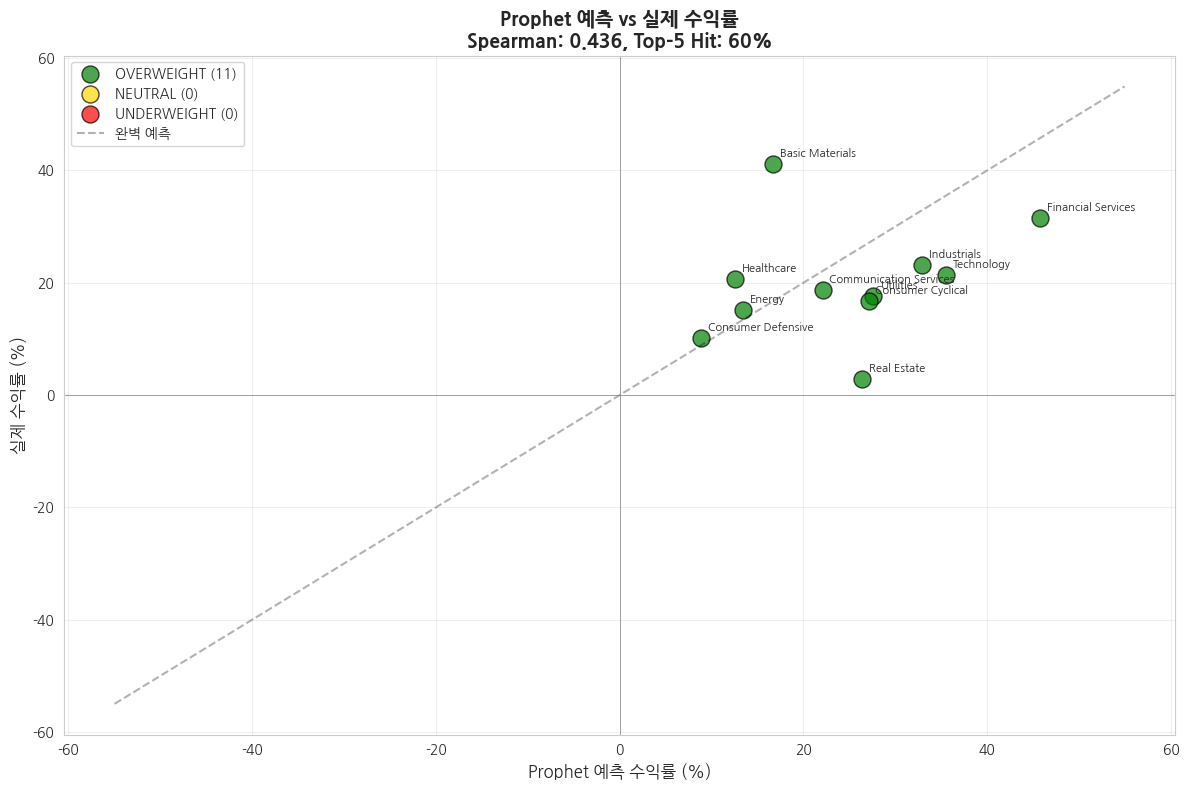

In [48]:
# =============================================================================
# 예측 vs 실제 수익률 산점도
# - X축: Prophet 예측 수익률
# - Y축: 실제 수익률
# - 대각선에 가까울수록 예측 정확
# - 1,3사분면: 방향 예측 성공
# - 2,4사분면: 방향 예측 실패
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 8))

colors = {'OVERWEIGHT': 'green', 'NEUTRAL': 'gold', 'UNDERWEIGHT': 'red'}

for rec in ['OVERWEIGHT', 'NEUTRAL', 'UNDERWEIGHT']:
    subset = df_strategy[df_strategy['Recommendation'] == rec]
    ax.scatter(
        subset['Predicted_Return'],
        subset['Actual_Return'],
        c=colors[rec],
        s=150,
        alpha=0.7,
        label=f"{rec} ({len(subset)})",
        edgecolors='black'
    )
    
    for _, row in subset.iterrows():
        ax.annotate(
            row['Sector'],
            (row['Predicted_Return'], row['Actual_Return']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8
        )

# 완벽 예측선
lim = max(abs(df_strategy['Predicted_Return'].max()), abs(df_strategy['Actual_Return'].max())) * 1.2
ax.plot([-lim, lim], [-lim, lim], 'k--', alpha=0.3, label='완벽 예측')

# 0선
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='-', linewidth=0.5)

ax.set_xlabel('Prophet 예측 수익률 (%)', fontsize=12)
ax.set_ylabel('실제 수익률 (%)', fontsize=12)
ax.set_title(f'Prophet 예측 vs 실제 수익률\nSpearman: {spearman_corr:.3f}, Top-5 Hit: {hit_rate_5:.0f}%', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '04_predicted_vs_actual_return.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.2 섹터별 수익률 비교 바 차트

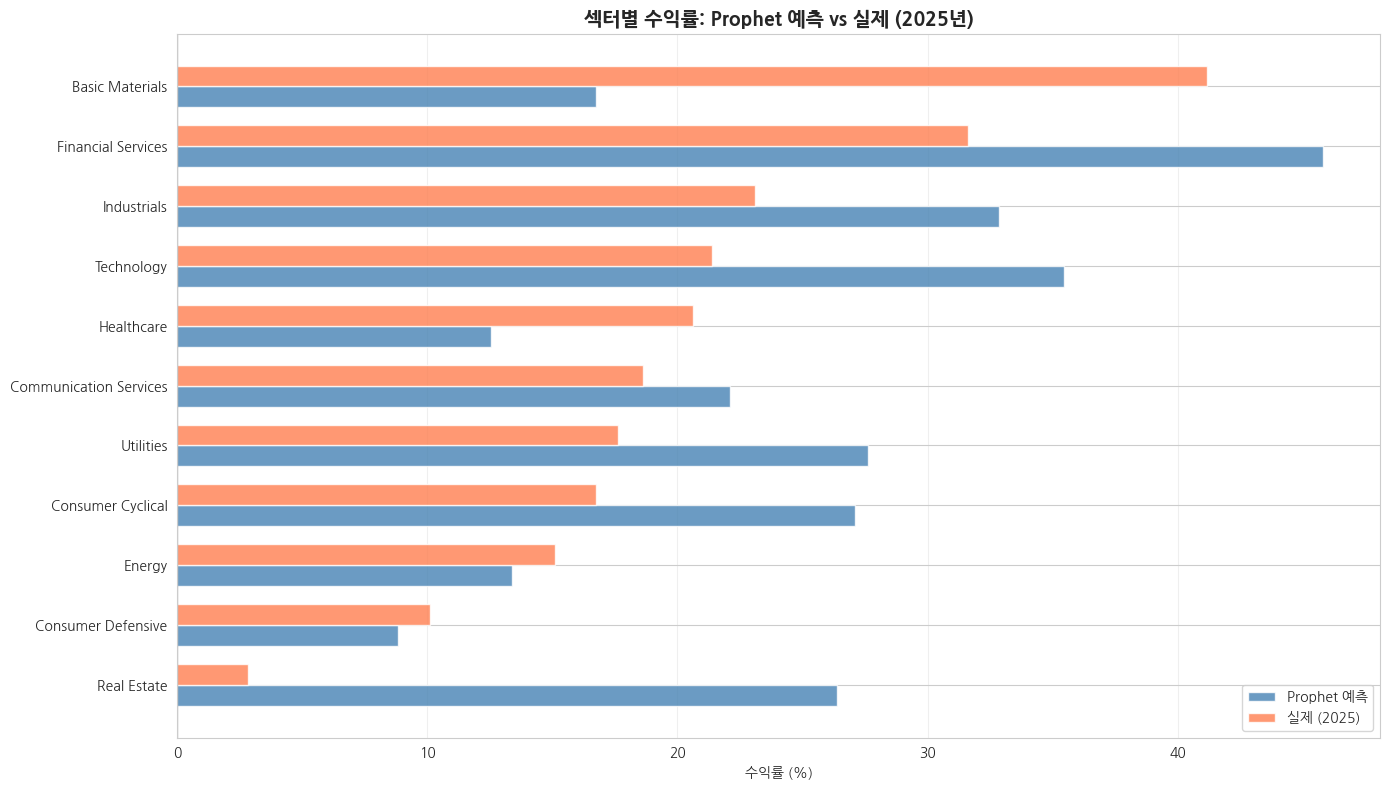

In [49]:
# =============================================================================
# 섹터별 수익률 비교 바 차트
# - 파란색: Prophet 예측 수익률
# - 주황색: 실제 수익률
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(df_strategy))
width = 0.35

df_plot = df_strategy.sort_values('Actual_Return', ascending=True)

bars1 = ax.barh(x - width/2, df_plot['Predicted_Return'], width, label='Prophet 예측', color='steelblue', alpha=0.8)
bars2 = ax.barh(x + width/2, df_plot['Actual_Return'], width, label='실제 (2025)', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(df_plot['Sector'])
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('수익률 (%)')
ax.set_title('섹터별 수익률: Prophet 예측 vs 실제 (2025년)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '05_sector_return_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.3 섹터별 예측 vs 실제 차트

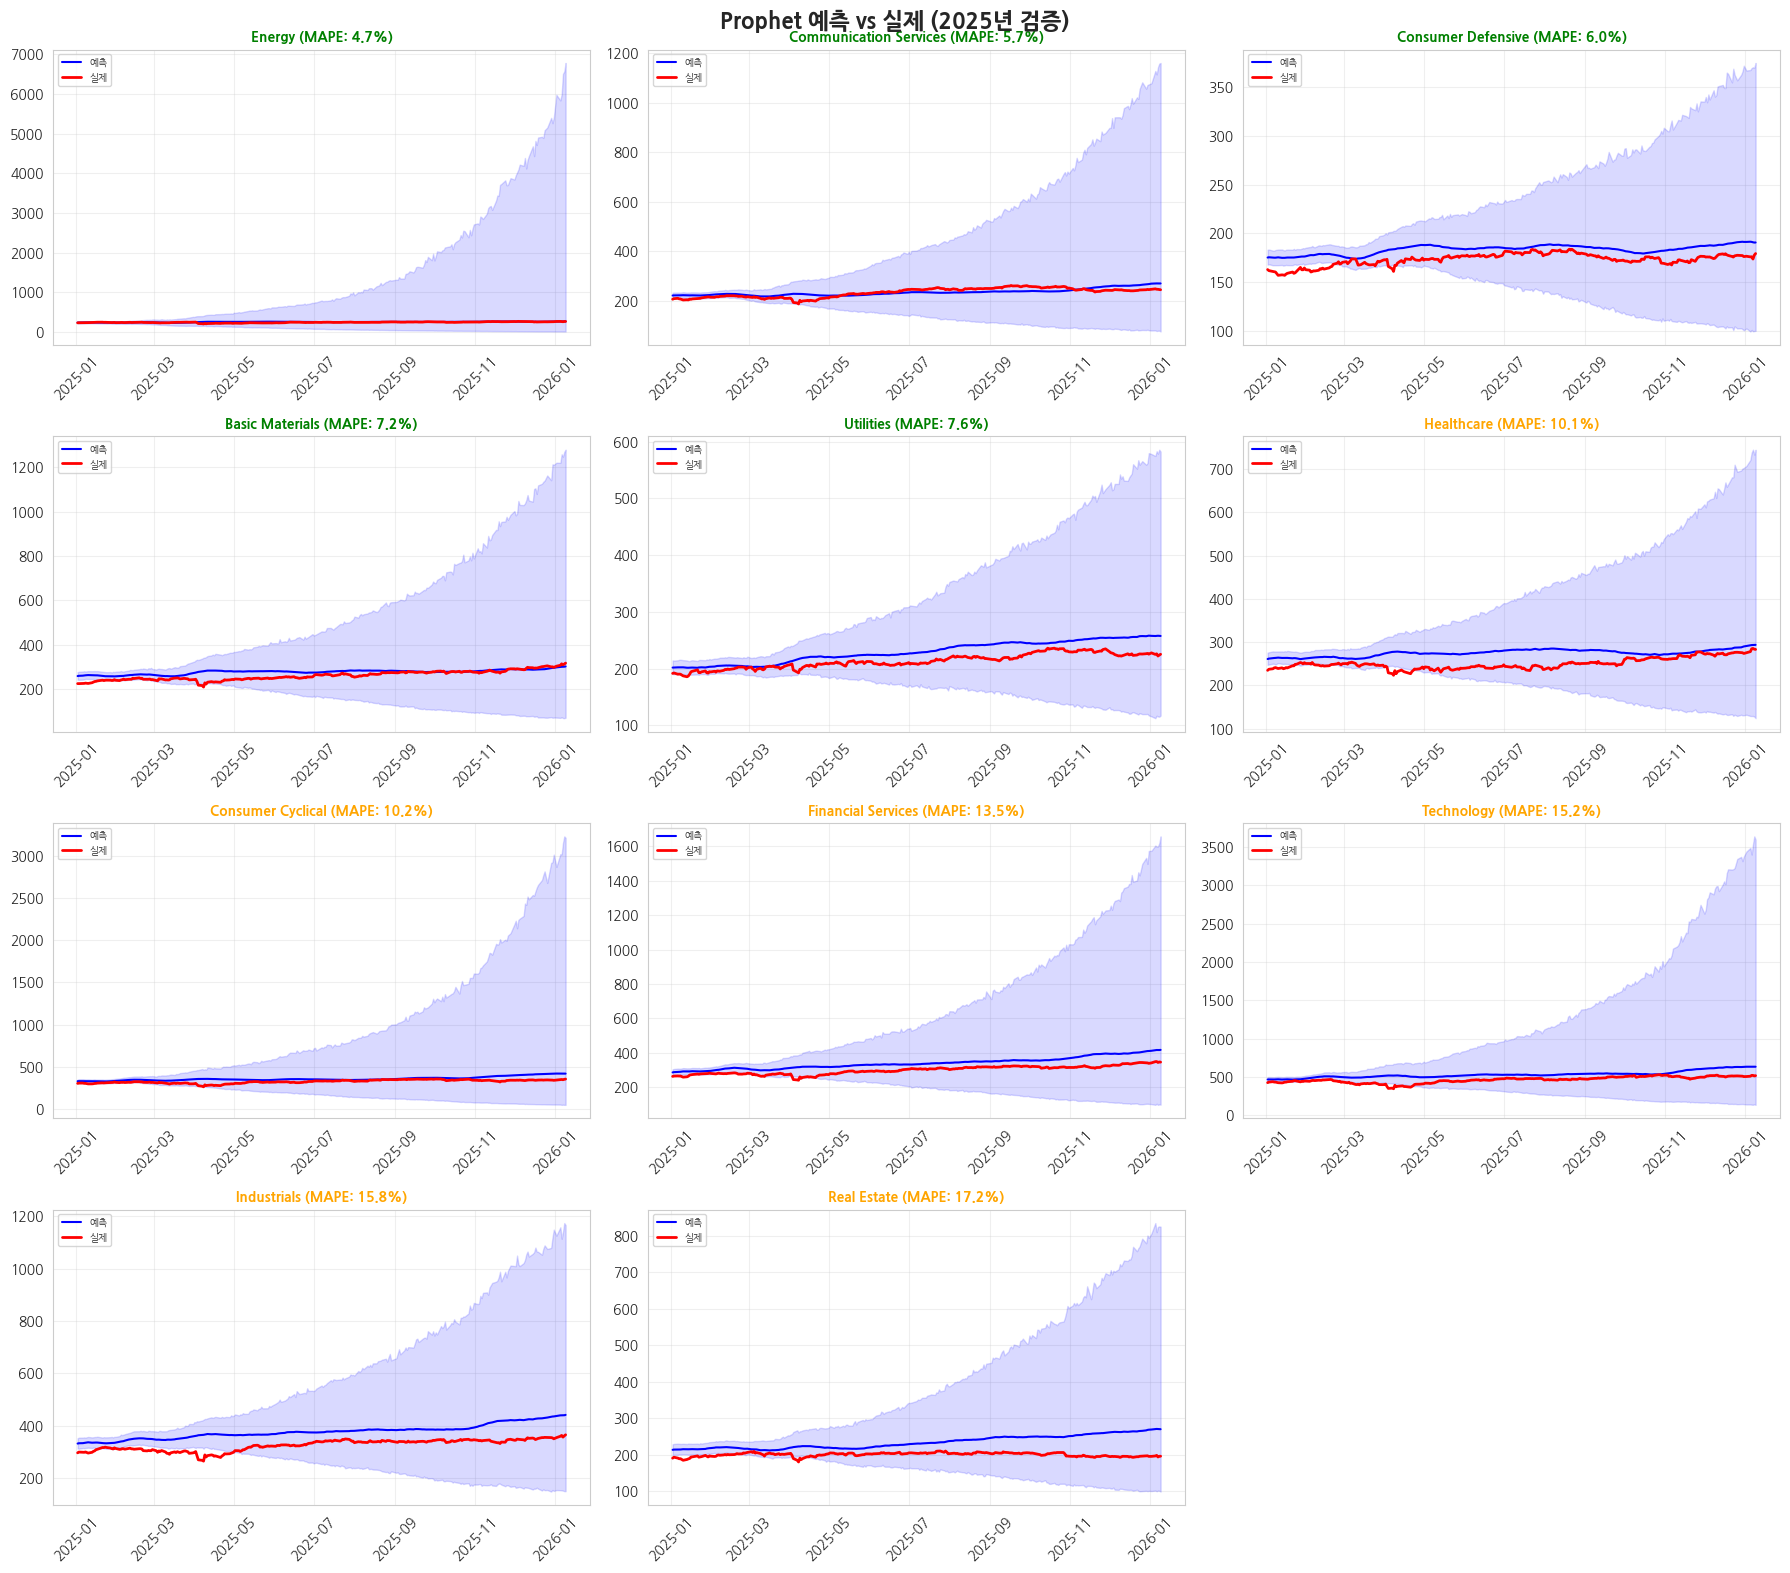

In [50]:
# =============================================================================
# 섹터별 Prophet 예측 vs 실제 시계열 차트
# - 각 섹터의 예측값(파란선)과 실제값(빨간선) 비교
# - MAPE 기준으로 정렬
# =============================================================================

n_sectors = len(sectors)
n_cols = 3
n_rows = (n_sectors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
fig.suptitle('Prophet 예측 vs 실제 (2025년 검증)', fontsize=16, fontweight='bold')
axes = axes.flatten()

sorted_sectors = df_eval.sort_values('MAPE')['Sector'].tolist()

for idx, sector in enumerate(sorted_sectors):
    ax = axes[idx]
    
    result = next(r for r in evaluation_results if r['Sector'] == sector)
    comparison = result['Comparison_Data']
    
    # 예측값
    ax.plot(comparison['ds'], comparison['yhat'], 'b-', linewidth=1.5, label='예측')
    ax.fill_between(
        comparison['ds'],
        comparison['yhat_lower'],
        comparison['yhat_upper'],
        color='blue', alpha=0.15
    )
    
    # 실제값
    ax.plot(comparison['ds'], comparison['actual'], 'r-', linewidth=2, label='실제')
    
    # 제목
    mape = result['MAPE']
    color = 'green' if mape < 10 else ('orange' if mape < 20 else 'red')
    ax.set_title(f"{sector} (MAPE: {mape:.1f}%)", fontsize=10, fontweight='bold', color=color)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=7)

for idx in range(n_sectors, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '06_prophet_vs_actual_all_sectors.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Section 8. 결과 저장

In [51]:
# 평가 결과
df_eval.to_csv(OUTPUT_DIR / 'prophet_evaluation_results.csv', index=False)
print(f"평가 결과 저장: prophet_evaluation_results.csv")

# 전략 결과
df_strategy.to_csv(OUTPUT_DIR / 'sector_rotation_backtest.csv', index=False)
print(f"백테스팅 결과 저장: sector_rotation_backtest.csv")

# 순위 비교
df_rank.to_csv(OUTPUT_DIR / 'sector_rank_comparison.csv', index=False)
print(f"순위 비교 저장: sector_rank_comparison.csv")

# Tableau용
df_strategy.to_csv(TABLEAU_DIR / 'prophet_sector_backtest.csv', index=False)
print(f"Tableau용 저장: prophet_sector_backtest.csv")

평가 결과 저장: prophet_evaluation_results.csv
백테스팅 결과 저장: sector_rotation_backtest.csv
순위 비교 저장: sector_rank_comparison.csv
Tableau용 저장: prophet_sector_backtest.csv


---

## Section 9. 최종 요약

In [53]:
print("\n" + "=" * 70)
print("Prophet 섹터 분석 백테스팅 최종 요약")
print("=" * 70)

print(f"\n[데이터 기간]")
print(f"  Train: {df_train['Date'].min().date()} ~ {df_train['Date'].max().date()}")
print(f"  Test (답지): {df_test['Date'].min().date()} ~ {df_test['Date'].max().date()}")

print(f"\n[개선 사항]")
print(f"  - 섹터 인덱스: 종가 평균 → 수익률 기반 지수 (황제주 편향 제거)")
print(f"  - 휴장일 처리: 미국 시장 휴장일 {len(US_HOLIDAYS)}개 반영")

print(f"\n[기본 성능 지표]")
print(f"  평균 MAPE: {df_eval['MAPE'].mean():.2f}%")
print(f"  평균 방향 정확도: {df_eval['Direction_Accuracy'].mean():.1f}%")

print(f"\n[핵심 성능 지표]")
print(f"  Spearman Rank Correlation: {spearman_corr:.4f} (p={spearman_pvalue:.4f})")
print(f"  Top-3 Hit Rate: {hit_rate_3:.1f}% ({len(hits_3)}/3)")
print(f"  Top-5 Hit Rate: {hit_rate_5:.1f}% ({len(hits_5)}/5)")

print(f"\n[섹터 로테이션 전략 성과]")
print(f"  전략 성공률: {success_rate:.1f}%")
print(f"  Prophet Top-5 수익률: {top5_return:+.2f}%")
print(f"  시장 평균 수익률: {market_return:+.2f}%")
print(f"  Top-5 Alpha: {alpha_top5:+.2f}%p")

print(f"\n[예측 상위 섹터 vs 실제 상위 섹터]")
print(f"  예측 Top-5: {pred_top5}")
print(f"  실제 Top-5: {actual_top5}")
print(f"  적중: {hits_5}")

print("\n" + "=" * 70)
print("백테스팅 분석 완료")
print("=" * 70)


Prophet 섹터 분석 백테스팅 최종 요약

[데이터 기간]
  Train: 2018-11-30 ~ 2024-12-31
  Test (답지): 2025-01-02 ~ 2026-01-09

[개선 사항]
  - 섹터 인덱스: 종가 평균 → 수익률 기반 지수 (황제주 편향 제거)
  - 휴장일 처리: 미국 시장 휴장일 87개 반영

[기본 성능 지표]
  평균 MAPE: 10.29%
  평균 방향 정확도: 51.0%

[핵심 성능 지표]
  Spearman Rank Correlation: 0.4364 (p=0.1797)
  Top-3 Hit Rate: 66.7% (2/3)
  Top-5 Hit Rate: 60.0% (3/5)

[섹터 로테이션 전략 성과]
  전략 성공률: 90.9%
  Prophet Top-5 수익률: +22.09%
  시장 평균 수익률: +19.90%
  Top-5 Alpha: +2.19%p

[예측 상위 섹터 vs 실제 상위 섹터]
  예측 Top-5: ['Financial Services', 'Technology', 'Industrials', 'Utilities', 'Consumer Cyclical']
  실제 Top-5: ['Basic Materials', 'Financial Services', 'Industrials', 'Technology', 'Healthcare']
  적중: ['Financial Services', 'Technology', 'Industrials']

백테스팅 분석 완료


---

## 결론 및 인사이트

### 핵심 평가 지표 해석

| 지표 | 값 | 해석 |
|------|-----|------|
| **Spearman Correlation** | - | 예측 순위와 실제 순위의 상관관계 |
| **Top-3 Hit Rate** | - | 상위 3개 섹터 적중률 |
| **Top-5 Hit Rate** | - | 상위 5개 섹터 적중률 |
| **Alpha** | - | 시장 대비 초과 수익률 |

### 활용 방안

1. **Spearman > 0.5**: 순위 예측력 있음 → 섹터 로테이션 전략 활용 가능
2. **Top-5 Hit Rate > 60%**: 상위권 예측 신뢰 가능 → 집중 투자 고려
3. **Alpha > 0**: Prophet 전략이 시장 대비 우위 → 전략 채택

### 한계점 및 개선 방향

1. **외생 변수 미반영**: 금리, 환율, 뉴스 등 거시 요인
2. **단기 예측 한계**: Prophet은 추세 예측에 강점, 단기 변동 예측은 약함
3. **앙상블 고려**: LSTM, XGBoost 등과 결합하여 예측력 향상

---

### 다음 단계: Step 2 (K-Means Clustering)

예측 상위 섹터 내에서 종목 군집화를 진행합니다.